# Exploratory data analysis in Seaborn

In this lecture, we'll talk about EDA (exploratory data analysis) using the python framework seaborn. EDA is the process of using graphs to uncover features in your data often interactively. EDA is hard to quantify, but is touted by most applied data scientists as a crucial component of their craft. EDA is often summarized by the famous sayings

*A picture is worth a 1,000 words*

Or saying how impactful intrer-ocular content is (i.e. when information hits you right between the eyes).

I'm using Seaborn as the framework. There's several plotting frameworks in python, but I find that seaborn has the nicest default plotting options. 

Let's start with loading up some libraries.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
## this sets some style parameters
sns.set()


First let's download the data. Then we'll read it in and drop some columns that aren't needed for this analysis.

In [2]:
## Getting the data
! if [ ! -e kirby21.csv ] ; \
  then wget https://raw.githubusercontent.com/jkrachm2/Data-Science/master/Master%20Repo/ds4bme_intro-master/data/kirby21.csv; \
fi

--2020-03-23 22:20:09--  https://raw.githubusercontent.com/jkrachm2/Data-Science/master/Master%20Repo/ds4bme_intro-master/data/kirby21.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1611966 (1.5M) [text/plain]
Saving to: ‘kirby21.csv’

kirby21.csv         100%[===================>]   1.54M  --.-KB/s    in 0.08s   

2020-03-23 22:20:09 (19.7 MB/s) - ‘kirby21.csv’ saved [1611966/1611966]



In [3]:
## Reading it in, keeping only volume
df = pd.read_csv("https://raw.githubusercontent.com/jkrachm2/Data-Science/master/Master%20Repo/ds4bme_intro-master/data/kirby21.csv")
df = df.drop(['Unnamed: 0', 'rawid', 'min', 'max', 'mean', 'std'],\
             axis = 1)
df.head(4)




,roi,volume,type,level,id,icv,tbv
0,Telencephalon_L,531111,1,1,127,1378295,1268519
1,Telencephalon_R,543404,1,1,127,1378295,1268519
2,Diencephalon_L,9683,1,1,127,1378295,1268519
3,Diencephalon_R,9678,1,1,127,1378295,1268519


Let's look at the Type 1 Level 1 data and create a variable called `comp` which is brain composition, defined as the regional volumes over total brain volume. We'll do this by selecting `roi` and comp then grouping by `roi` and taking the mean of the compostions. 

In [0]:
## Extract the Type 1 Level 1 data
t1l1 = df.loc[(df.type == 1) & (df.level == 1)]
## Create a new column based on ICV
t1l1 = t1l1.assign(icv = sum(t1l1.volume))

In [5]:
## create a composition variable
t1l1 = t1l1.assign(comp = lambda x: x.volume / x.tbv)

## get the mean of the composition variable across
## subjects by ROI
summary = t1l1[['roi', 'comp']].groupby('roi', as_index=False).mean()
print(summary)

               roi      comp
0              CSF  0.073708
1   Diencephalon_L  0.007563
2   Diencephalon_R  0.007634
3    Mesencephalon  0.008647
4    Metencephalon  0.124883
5   Myelencephalon  0.003785
6  Telencephalon_L  0.420305
7  Telencephalon_R  0.427184


OK, let's try our first plot, a seaborn bar plot.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

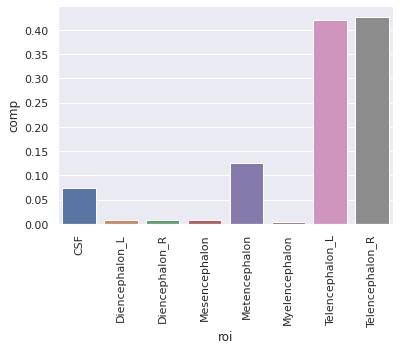

In [6]:
g = sns.barplot(x='roi', y = 'comp', data = summary)
## this is the matplotlib command for rotating 
## axis tick labels by 90 degrees.
plt.xticks(rotation = 90)

Unfortunately, seaborn doesn't have a stakced bar chart. However, pandas does have one built in. To do this, however, we have to create a version of the data with ROIs as the columns. This is done with a pivot statement.

In [7]:
t1l1pivot = t1l1.pivot(index = 'id', columns = 'roi', values = 'volume')
t1l1pivot.head(4)



roi,CSF,Diencephalon_L,Diencephalon_R,Mesencephalon,Metencephalon,Myelencephalon,Telencephalon_L,Telencephalon_R
id,,,,,,,,
127,109776,9683,9678,10268,159402,4973,531111,543404
142,107334,9156,9071,10516,165803,4912,545603,552216
239,94254,8937,9004,9070,124504,4023,483107,490805
346,67156,8828,8933,9788,135090,4428,558849,568830


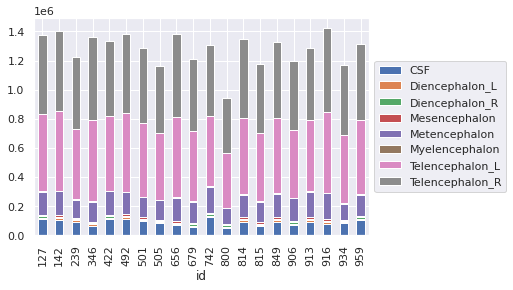

In [8]:
t1l1pivot.plot(kind='bar', stacked=True, legend= False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


Let's do some scatterplots. Let's look at bilateral symmetry in the telencephalon. 

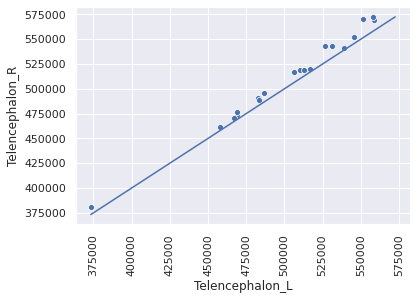

In [9]:
sns.scatterplot(x = 'Telencephalon_L', y = 'Telencephalon_R', data = t1l1pivot)
plt.xticks(rotation = 90)

#plot an identity line from the data min to the data max
x1 = min([t1l1pivot.Telencephalon_L.min(), t1l1pivot.Telencephalon_R.min()])
x2 = max([t1l1pivot.Telencephalon_L.max(), t1l1pivot.Telencephalon_R.max()])
plt.plot([x1, x2], [x1 , x2])



This plot has the issue that there's a lot of blank space. This is often addressed via a mean difference plot. This plot shows (X+Y) / 2 versus (X-y). This is basically just rotating the plot above by 45 degrees to get rid of all of the blank space around the diagonal line. Alternatively, you could plot (log(x) + log(y)) / 2 versus log(X) - log(Y). This plots the log of the geometric mean of the two observations versus the log of their ratio. Sometimes people use log base 2 or log base 10.

(array([12.8 , 12.85, 12.9 , 12.95, 13.  , 13.05, 13.1 , 13.15, 13.2 ,
        13.25, 13.3 ]), <a list of 11 Text major ticklabel objects>)

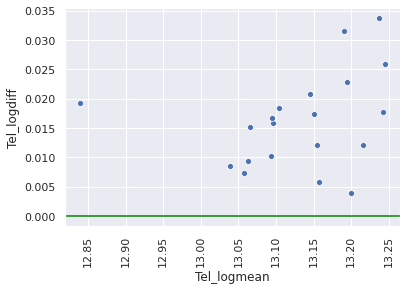

In [10]:
t1l1pivot = t1l1pivot.assign(Tel_logmean = lambda x: (np.log(x.Telencephalon_L) * .5 +  np.log(x.Telencephalon_R)* .5))
t1l1pivot = t1l1pivot.assign(Tel_logdiff = lambda x: (np.log(x.Telencephalon_R) -  np.log(x.Telencephalon_L)))
sns.scatterplot(x = 'Tel_logmean', y = 'Tel_logdiff', data = t1l1pivot)
plt.axhline(0, color='green')
plt.xticks(rotation = 90)



Thus, apparently, the *right* side is always a little bigger than the *left* and the scale of the ratio is $e^{0.02}$ while the scale of the geometric mean is $e^{13}$. Note, $\exp(x) \approx 1 + x$  for $x \approx 0$. So it's about 2% larger. A note about right versus left in imaging. Often the labels get switched as there are different conventions (is it the right of the subject or the right of the viewer when looking straight at the subject?). Typically, it's known that some of the areas of subject's left hemisphere are larger and so it's probably radiological (right of the viewer) convention here. [Here's](https://www.dana.org/uploadedFiles/BAW/Brain_Brief_Right_Brain-Left_Brain_Final.pdf) a nicely done article about right versus left brain.

Also, in case you don't believe me, here's a plot of $e^x$ versus $1+x$ for values up to 0.1. This is obtained as the Taylor expasion for $e^x$ around 0.

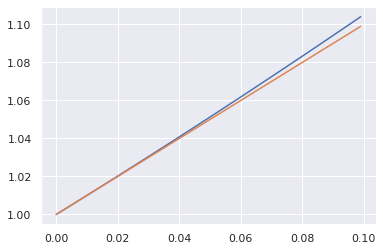

In [11]:
x = np.arange(0, .1, .001)
ex = np.exp(x)

sns.lineplot(x, ex)
plt.plot(x, x + 1)

